In [1]:
#Distributions and Modules
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch import distributions
import pandas as pd
import numpy as np
from torch import optim

In [2]:
def Normalization(df):
    df.iloc[:,2:]= df.iloc[:,2:].apply(lambda x: ((x-x.mean()) / (x.std())))
    return df

In [6]:
def preprocessing(path):
    
    df = pd.read_csv(path, header=None, delimiter=' ')
    
    #Normalize the data
    df = Normalization(df)
    
    #Drop the columns which has all values as Nan
    df.dropna(axis=1, how='all', inplace=True)
    
    #Get Rewards for each time step : 0 except last time step where reward is -100
    df['Counter'] = df.index
    lastRowIndex = df.groupby(0).last().Counter.tolist()
    df['reward'] = df['Counter'].apply(lambda x : -100 if x in lastRowIndex else 0 )
    df.drop(columns=['Counter'],inplace=True)
    
    #Rename columns
    df.rename(columns={0: "machine", 1: "time"}, inplace=True)
    
    #Calculate Monte Carlo Value for each row
    df1 = df.groupby('machine').last()[['time']].reset_index()
    df = pd.merge(df, df1, on = 'machine', how = 'left').rename(columns ={'time_x':'time','time_y':'lastTimeStamp'})
    df['MC_Val'] = (gamma ** (df['lastTimeStamp'] - df['time'] )) * (-100)
    df = df.drop(columns='lastTimeStamp')
    
    return df

In [7]:
df = preprocessing("/home/abc/Berkeley/Prof_Ram/CMAPSSData/train_FD001.txt")

## We have added the reward and Val column. We will be using the Val column for the Monte Carlo return gamma**(T-t)  X  -100

## Now lets build the Neural network for the predictron

In [6]:
#Neural network for Observation - Hidden State

In [34]:
class NN_OH(nn.Module):
    def __init__(self, input_size, out_size):
        super(NN_OH,self).__init__()
        self.fc1 = nn.Linear(input_size,32)
        self.fc2 = nn.Linear(32,16)
        self.fc3 = nn.Linear(16,out_size)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [35]:
#Neural network for Hidden State - Reward, Gamma, Lambda

In [36]:
class NN_reward(nn.Module):
    def __init__(self, input_size):
        super(NN_reward,self).__init__()
        self.fc1 = nn.Linear(input_size,32)
        self.fc2 = nn.Linear(32,16)
        self.fc3 = nn.Linear(16,3)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [83]:
#Neural network for Hidden State - Value
class NN_val(nn.Module):
    def __init__(self, input_size):
        super(NN_val,self).__init__()
        self.fc1 = nn.Linear(input_size,32)
        self.fc2 = nn.Linear(32,16)
        self.fc3 = nn.Linear(16,1)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [38]:
##Neural Network which will take my current hidden state to the next hidden state

In [39]:
class NN_HH(nn.Module):
    def __init__(self, input_size):
        super(NN_HH,self).__init__()
        self.fc1 = nn.Linear(input_size,32)
        self.fc2 = nn.Linear(32,16)
        self.fc3 = nn.Linear(16,input_size)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [98]:
#Now we have all the required neural networks for the predictron. Lets build the Predictron

class Predictronv3(nn.Module):
    def __init__(self, obs_size, hid_size, k=10):
        super(Predictronv3,self).__init__()
        
        #Instantiate Neural Network for Observation-Hidden State
        self.OH = NN_OH(obs_size, hid_size)
        
        #Instantiate Neural Network for Hidden State - Reward, Value
        self.HR = NN_reward(hid_size)
        
        #Instantiate Neural Network for Hidden State - Val
        self.HV = NN_val(hid_size)
        
        #Instantiate Neural Network for Hidden State - Next Hidden State
        self.HH = NN_HH(hid_size)
        
        #K-step return
        self.k = k
        
    def forward(self, x):
        #Predictron core will output the value estimate for the current observation. We will input x (observation) 
        #and get value estimate. This implementation is for a k-step return which can be extended to TD(lambda) return
        
        #First step: Get the Hidden state for the current observation
        
        x = self.OH(x)
        #Get the reward, lambda, gamma for current hidden state
        reward = self.HR(x)[:,0].reshape(-1,1)
        gamma = self.HR(x)[:,1].reshape(-1,1)
        _lambda = self.HR(x)[:,2].reshape(-1,1)
        
        #Get value of the current hidden state
        val = self.HV(x)
        #print(val.shape)
        #Get glk for 0th step
        glk = (1-_lambda)*val + _lambda* reward
        #print(glk.shape)
        
        #Store gamma and lambda as prev lambda
        prev_gamma = gamma
        prev_lambda = _lambda
        
        #Now run the loop for k steps
        for i in range(1, self.k + 1):
            #Move to next hidden step
            x = self.HH(x)
            
            #Get the reward, lambda, gamma for current hidden state
            reward = self.HR(x)[:,0].reshape(-1,1)
            gamma = self.HR(x)[:,1].reshape(-1,1)
            _lambda = self.HR(x)[:,2].reshape(-1,1)
            
            #Get value of the current hidden state
            val = self.HV(x)
            
            #Calculate the lambda return
            glk += (prev_gamma*prev_lambda) * ((1-_lambda)*val + _lambda* reward)
        

        return glk.reshape(-1,1)

In [99]:
def getXY(data):
    x = torch.tensor(data.iloc[:, 2:-2].values).float()
    y_target = torch.tensor(data.iloc[:,-1].values).float()
    y_target = y_target.reshape(-1,1)
    
    return x, y_target

In [100]:
x, y_target = getXY(df)

In [101]:
y_target.shape

torch.Size([20631, 1])

In [102]:
#Defining the loss function and Initialising the Predictron core
k=10
loss_fn = nn.MSELoss()
core = Predictronv3(x.shape[1], 4, k)
optimizer = optim.Adam(core.parameters(), lr = 1e-3) 

In [103]:
core

Predictronv3(
  (OH): NN_OH(
    (fc1): Linear(in_features=21, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=16, bias=True)
    (fc3): Linear(in_features=16, out_features=4, bias=True)
  )
  (HR): NN_reward(
    (fc1): Linear(in_features=4, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=16, bias=True)
    (fc3): Linear(in_features=16, out_features=3, bias=True)
  )
  (HV): NN_val(
    (fc1): Linear(in_features=4, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=16, bias=True)
    (fc3): Linear(in_features=16, out_features=1, bias=True)
  )
  (HH): NN_HH(
    (fc1): Linear(in_features=4, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=16, bias=True)
    (fc3): Linear(in_features=16, out_features=4, bias=True)
  )
)

In [104]:
n_epochs = 50 # or whatever
batch_size = 256# or whatever
losses=[]
for epoch in range(n_epochs):

    # x is our input
    permutation = torch.randperm(x.size()[0])

    for i in range(0,x.size()[0], batch_size):
        optimizer.zero_grad()

        indices = permutation[i:i+batch_size]
        batch_x, batch_y = x[indices], y_target[indices]

        # in case you wanted a semi-full example
        outputs = core.forward(batch_x)
        loss = loss_fn(outputs,batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    print("Loss after:"+str(epoch)+" iterations is :"+ str(loss))

Loss after:0 iterations is :tensor(65.3985, grad_fn=<MseLossBackward>)
Loss after:1 iterations is :tensor(34.8556, grad_fn=<MseLossBackward>)
Loss after:2 iterations is :tensor(16.9897, grad_fn=<MseLossBackward>)
Loss after:3 iterations is :tensor(31.2961, grad_fn=<MseLossBackward>)
Loss after:4 iterations is :tensor(17.8429, grad_fn=<MseLossBackward>)
Loss after:5 iterations is :tensor(38.1178, grad_fn=<MseLossBackward>)
Loss after:6 iterations is :tensor(18.9797, grad_fn=<MseLossBackward>)
Loss after:7 iterations is :tensor(25.4680, grad_fn=<MseLossBackward>)
Loss after:8 iterations is :tensor(14.5285, grad_fn=<MseLossBackward>)
Loss after:9 iterations is :tensor(40.9442, grad_fn=<MseLossBackward>)
Loss after:10 iterations is :tensor(26.3427, grad_fn=<MseLossBackward>)
Loss after:11 iterations is :tensor(21.1817, grad_fn=<MseLossBackward>)
Loss after:12 iterations is :tensor(24.2231, grad_fn=<MseLossBackward>)
Loss after:13 iterations is :tensor(24.7969, grad_fn=<MseLossBackward>)
Lo

Text(0.5, 1.0, 'Training Loss for Predictron with 10-step return')

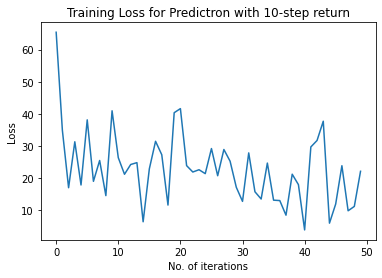

In [105]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel("No. of iterations")
plt.ylabel("Loss")
plt.title("Training Loss for Predictron with "+str(k)+"-step return")

In [106]:
for p in core.parameters():
    print(p.shape)

torch.Size([32, 21])
torch.Size([32])
torch.Size([16, 32])
torch.Size([16])
torch.Size([4, 16])
torch.Size([4])
torch.Size([32, 4])
torch.Size([32])
torch.Size([16, 32])
torch.Size([16])
torch.Size([3, 16])
torch.Size([3])
torch.Size([32, 4])
torch.Size([32])
torch.Size([16, 32])
torch.Size([16])
torch.Size([1, 16])
torch.Size([1])
torch.Size([32, 4])
torch.Size([32])
torch.Size([16, 32])
torch.Size([16])
torch.Size([4, 16])
torch.Size([4])


## Testing

In [107]:
df_test = preprocessing("/home/abc/Berkeley/Prof_Ram/CMAPSSData/test_FD001.txt")

In [108]:
x_test, y_test = getXY(df_test)

In [109]:
x_test.shape

torch.Size([13096, 21])

In [110]:
y_test.shape

torch.Size([13096, 1])

In [111]:
predict_test = core.forward(x_test)

In [112]:
loss_fn(predict_test, y_test)

tensor(329.0135, grad_fn=<MseLossBackward>)

In [113]:
df_test.iloc[20:40, 2:-2]

,2,3,5,6,7,8,9,10,11,12,...,14,15,16,17,18,19,20,21,24,25
20,1.730242,-0.694615,0.999962,0.561019,-0.959213,-0.827618,0.999962,0.175653,0.972392,-0.364968,...,0.999962,-0.286877,0.540139,0.684565,-1.186405,-0.291078,0.999962,-0.463388,0.476412,0.793594
21,0.549865,0.325687,0.999962,-0.062579,-1.063145,-0.100976,0.999962,0.175653,-0.480742,-1.235415,...,0.999962,-0.797297,-0.603480,-0.544922,-0.987163,1.029187,0.999962,-0.463388,0.335250,0.490456
22,0.413667,-0.014413,0.999962,-0.885728,-0.117764,-1.442123,0.999962,0.175653,1.926470,-0.539057,...,0.999962,-1.154590,0.450794,-0.193640,-0.783014,-0.491013,0.999962,0.347263,1.464549,-0.203788
23,-0.267320,-0.354514,0.999962,-0.386850,1.237349,-0.685579,0.999962,0.175653,-0.715592,-0.016789,...,0.999962,-0.644171,0.558008,0.860206,-0.809514,-0.635794,0.999962,0.347263,0.335250,0.729400
24,1.276251,-1.034715,0.999962,-0.561457,-1.133099,-0.673617,0.999962,0.175653,0.003636,0.679568,...,0.999962,-0.235835,0.915389,0.157642,-1.010719,-0.866755,0.999962,0.347263,0.476412,0.508288
25,2.138835,-1.714917,0.999962,0.012253,-0.963210,0.498577,0.999962,0.175653,1.221920,0.157300,...,0.999962,-0.440003,0.361449,-0.017999,-0.964589,-1.066690,0.999962,-1.274039,-0.864631,0.237247
26,-0.312719,0.325687,0.999962,-0.985504,-0.289651,-0.661656,0.999962,0.175653,0.869645,0.331389,...,0.999962,-0.388961,0.129151,-0.896204,-1.149109,0.812016,0.999962,-0.463388,-0.158819,0.681849
27,1.003856,1.686090,0.999962,-1.359663,1.229354,-0.515132,0.999962,0.175653,-0.289927,-0.016789,...,0.999962,-1.869178,0.164889,-0.017999,-0.398270,0.729284,0.999962,-0.463388,-0.441143,0.171865
28,0.640663,0.325687,0.999962,-1.309775,-0.189717,-0.990588,0.999962,0.175653,0.576083,0.157300,...,0.999962,0.019375,1.147687,-0.017999,-0.571012,-0.160085,0.999962,-0.463388,0.899900,0.313329
29,-1.129903,1.345990,0.999962,0.785514,-0.475529,-0.562977,0.999962,0.175653,0.502692,0.331389,...,0.999962,-0.082709,0.057675,0.508924,-0.408085,-0.511696,0.999962,-1.274039,1.393968,0.845900


In [114]:
df_test.groupby('machine').last()

,time,2,3,5,6,7,8,9,10,11,...,16,17,18,19,20,21,24,25,reward,MC_Val
machine,,,,,,,,,,,,,,,,,,,,,
1,31,-0.267320,1.345990,0.999962,0.261692,-1.374941,-0.870977,0.999962,0.175653,0.972392,...,0.075544,-0.193640,-0.867422,-0.808153,0.999962,0.347263,-0.582306,0.231303,-100,-100.0
2,49,0.822260,-0.354514,0.999962,0.186860,-0.301643,0.911237,0.999962,0.175653,-0.348639,...,-0.013802,0.333283,-1.182480,0.849935,0.999962,-1.274039,-0.582306,-0.879011,-100,-100.0
3,126,-0.721311,1.345990,0.999962,1.010010,0.329943,2.116325,0.999962,0.175653,-1.713704,...,-1.639885,1.211488,-0.734921,-0.480672,0.999962,1.968564,0.264669,-0.733981,-100,-100.0
4,106,0.549865,1.345990,0.999962,0.760570,1.285318,0.320655,0.999962,0.175653,-1.640314,...,0.236365,0.684565,-0.520956,1.294619,0.999962,1.968564,-2.205674,-0.922996,-100,-100.0
5,98,-0.585114,-1.374816,0.999962,-0.511569,0.367918,2.186597,0.999962,0.175653,-0.686236,...,-1.336111,1.387129,-1.296332,0.356990,0.999962,1.157913,-1.005793,0.902961,-100,-100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,97,-0.267320,1.005889,0.999962,-0.436738,0.555795,-1.016006,0.999962,0.175653,0.341233,...,0.986865,-1.071845,0.912017,-0.511696,0.999962,-1.274039,0.476412,1.484271,-100,-100.0
97,134,0.595264,-0.354514,0.999962,0.286636,-1.027168,0.924694,0.999962,0.175653,0.429301,...,-0.299706,-0.193640,1.622615,0.832699,0.999962,1.968564,-1.993930,-0.480772,-100,-100.0
98,121,0.776860,0.325687,0.999962,0.511131,2.280666,1.604985,0.999962,0.175653,-0.466064,...,-0.389052,0.333283,0.730442,-0.080800,0.999962,1.157913,-0.935212,0.297875,-100,-100.0


In [115]:
y_target[180:200,:]

tensor([[-3.1381e+01],
        [-3.4868e+01],
        [-3.8742e+01],
        [-4.3047e+01],
        [-4.7830e+01],
        [-5.3144e+01],
        [-5.9049e+01],
        [-6.5610e+01],
        [-7.2900e+01],
        [-8.1000e+01],
        [-9.0000e+01],
        [-1.0000e+02],
        [-8.1914e-12],
        [-9.1015e-12],
        [-1.0113e-11],
        [-1.1236e-11],
        [-1.2485e-11],
        [-1.3872e-11],
        [-1.5414e-11],
        [-1.7126e-11]])

In [116]:
y_test[20:40]

tensor([[ -34.8678],
        [ -38.7421],
        [ -43.0467],
        [ -47.8297],
        [ -53.1441],
        [ -59.0490],
        [ -65.6100],
        [ -72.9000],
        [ -81.0000],
        [ -90.0000],
        [-100.0000],
        [  -0.6363],
        [  -0.7070],
        [  -0.7855],
        [  -0.8728],
        [  -0.9698],
        [  -1.0775],
        [  -1.1973],
        [  -1.3303],
        [  -1.4781]])

In [117]:
core.forward(x_test[20:40,:])

tensor([[-0.1266],
        [-0.0077],
        [-0.0180],
        [-0.0393],
        [-0.0732],
        [-0.1652],
        [-0.0392],
        [-0.0406],
        [-0.0521],
        [-0.1707],
        [-0.1637],
        [-0.1978],
        [-0.1176],
        [-0.0929],
        [-0.1328],
        [-0.2042],
        [-0.0908],
        [-0.2661],
        [-0.3526],
        [-0.2334]], grad_fn=<ViewBackward>)

# Accessing the trained Predictron Core

In [73]:
core

Predictronv2(
  (fc1): NN_OH(
    (fc1): Linear(in_features=21, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=16, bias=True)
    (fc3): Linear(in_features=16, out_features=4, bias=True)
  )
  (fc2): NN_reward_val(
    (fc1): Linear(in_features=4, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=16, bias=True)
    (fc3): Linear(in_features=16, out_features=2, bias=True)
  )
  (fc3): NN_HH(
    (fc1): Linear(in_features=4, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=32, bias=True)
    (fc3): Linear(in_features=32, out_features=4, bias=True)
  )
)

In [118]:
#Sample
print(x[191],y_target[191])

tensor([ 0.4155, -0.0080,  1.0000,  1.7179,  1.7757,  2.0294,  1.0000,  0.1417,
        -2.3926,  3.1464, -1.4501,  1.0000,  2.6539, -1.8080,  3.1125, -1.7206,
         1.8439,  1.0000,  1.8010, -1.8605, -3.0005]) tensor([-100.])


In [119]:
hidden_state = core.OH(x[191])
print(hidden_state)

tensor([ 2.9286,  6.0982, -5.0383, -6.1791], grad_fn=<AddBackward0>)


In [120]:
#reward_sample, Reward, Gamma, Val
core.HR(hidden_state)

tensor([-3.7576,  2.9589,  2.7010], grad_fn=<AddBackward0>)

In [122]:
#Value
core.HV(hidden_state)

tensor([-8.2409], grad_fn=<AddBackward0>)

In [121]:
#Next hidden State
core.HH(hidden_state)

tensor([-0.5781,  3.4634, -2.7797, -1.6379], grad_fn=<AddBackward0>)

In [123]:
#Net output
core.forward(x[191].reshape(1,-1))

tensor([[-71.9248]], grad_fn=<ViewBackward>)

In [77]:
df.groupby('machine').last()

,time,2,3,5,6,7,8,9,10,11,...,16,17,18,19,20,21,24,25,reward,MC_Val
machine,,,,,,,,,,,,,,,,,,,,,
1,192,0.415519,-0.008022,0.999976,1.717950,1.775667,2.029443,0.999976,0.14168,-2.392645,...,-1.807964,3.112500,-1.720613,1.843870,0.999976,1.801015,-1.860455,-3.000487,-100,-100.0
2,287,-0.224536,2.039326,0.999976,2.337884,2.932057,2.433861,0.999976,0.14168,-1.929416,...,-2.174039,1.583000,1.667906,2.515780,0.999976,3.092369,-2.137086,-1.892875,-100,-100.0
3,179,0.552673,-0.008022,0.999976,1.657956,2.328582,2.143880,0.999976,0.14168,-1.646960,...,-2.553673,1.443954,5.849562,1.691891,0.999976,3.092369,-2.303064,-3.080856,-100,-100.0
4,189,-1.093181,-0.690471,0.999976,3.697739,3.520854,2.623848,0.999976,0.14168,-1.624363,...,-2.133364,0.887772,6.063442,2.198489,0.999976,3.092369,-2.081760,-1.746918,-100,-100.0
5,269,1.009855,1.015652,0.999976,1.557967,1.102058,2.422750,0.999976,0.14168,-2.934961,...,-2.106248,0.887772,3.616934,2.099836,0.999976,2.446692,-2.026434,-2.402801,-100,-100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,336,-1.413208,-1.714145,0.999976,2.117907,1.415213,2.576073,0.999976,0.14168,-2.923663,...,-3.028215,2.000136,0.014535,1.601236,0.999976,2.446692,-2.524369,-2.437905,-100,-100.0
97,202,0.644110,0.333203,0.999976,2.217897,3.284357,2.052775,0.999976,0.14168,-2.053697,...,-2.038456,0.748727,6.284136,2.281145,0.999976,2.446692,-2.911652,-1.582485,-100,-100.0
98,156,3.524355,-1.031695,0.999976,0.678061,2.160587,2.580518,0.999976,0.14168,-2.087592,...,-2.526556,2.278227,-1.128776,2.363800,0.999976,1.801015,-2.690347,-1.625902,-100,-100.0
